# Init

In [ ]:
import numpy as np

import hdbscan

import logging

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [68]:
logging.basicConfig(level=logging.DEBUG)

db_logger = logging.getLogger(name='debug')
db_logger.setLevel(logging.DEBUG)

In [ ]:
%cd ..
%load_ext autoreload

In [162]:
%autoreload 2
from src.MapData import MapData
from src.plotting_functions import plot_embedding

In [ ]:
map_data = MapData()
map_data.get_metadata()
map_data.get_map_dimensions()
map_data.load_wavelenths()

In [ ]:
fig = map_data.plot_random_spectrum(return_fig=True)
fig.savefig('./temp/random_spectrum.png')

In [ ]:
map_data.load_all_data()

# Intensity maps

## Total emissivity

In [ ]:
full_emissivities = map_data.spectra.sum(axis=1)

full_emissivities = full_emissivities.reshape(map_data.map_dimensions[::-1])
full_emissivities[::2,:] = full_emissivities[::2,::-1]

In [ ]:
fig,ax = plt.subplots(1,1)
ax.imshow(full_emissivities)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./temp/total_emissivity_map.png')

## max intensity

In [ ]:
max_intensity = map_data.spectra.max(axis=1)

max_intensity = max_intensity.reshape(map_data.map_dimensions[::-1])
max_intensity[::2,:] = max_intensity[::2,::-1]

In [ ]:
fig,ax = plt.subplots(1,1)
ax.imshow(max_intensity)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./temp/max_intensity_map.png')

## line intensity

In [ ]:
integral_range_half_width = 1

emission_line_center_position = np.argmax(map_data.random_spectrum)
emission_line_center = map_data.wvl[emission_line_center_position]
emission_line_boundaries = [
    emission_line_center - integral_range_half_width,
    emission_line_center + integral_range_half_width
]

emission_line_range = list(filter(
    lambda x: emission_line_boundaries[1] > x > emission_line_boundaries[0],
    map_data.wvl
))

integral_left_bound = np.where(map_data.wvl == np.min(emission_line_range))[0][0]
integral_right_bound = np.where(map_data.wvl == np.max(emission_line_range))[0][0]

In [ ]:
line_intensities = map_data.spectra[
    :,
    integral_left_bound:(integral_right_bound+1)
].copy()

line_intensity = np.subtract(
    line_intensities, 
    line_intensities.min(axis=1).reshape(-1,1),
).sum(axis=1)

line_intensity = line_intensity.reshape(map_data.map_dimensions[::-1])
line_intensity[::2,:] = line_intensity[::2,::-1]

In [ ]:
fig,ax = plt.subplots(1,1)
ax.imshow(line_intensity)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./temp/line_intensity_map.png')

# Full-spectral clustering

In [ ]:
STEP_SIZE = 40

## HDBSCAN

In [ ]:
dist_matrix = cosine_distances(map_data.spectra[::STEP_SIZE,:])
dist_matrix = dist_matrix.astype(np.float64)

In [ ]:
clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    # alpha=.01,
    approx_min_span_tree=True,
    gen_min_span_tree=False, 
    leaf_size=20,
    metric='precomputed',
    min_cluster_size=15,
    min_samples=5,
    cluster_selection_epsilon=.2,
    p=None,
    core_dist_n_jobs=3
)

clusterer.fit(dist_matrix)

In [ ]:
plot_labels = clusterer.labels_.copy()

counts, bins = np.histogram(
    plot_labels,
    bins=np.arange(-1,len(
        np.unique(plot_labels)
    ))
)

main_cluster_id = bins[np.argmax(counts)]

print(
    f'the most populous cluster is {main_cluster_id}'
)

main_cluster_cond = clusterer.labels_ == main_cluster_id

## k-means

In [ ]:
## 

# Embeddings

## PCA

In [ ]:
PC_COUNT = 18

pca_model = PCA(n_components=PC_COUNT)
pca_scores = pca_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

DEBUG:debug:embedding combinations: 153
DEBUG:debug:plot_count: 18
DEBUG:debug:cols, rows: 3, 3
c:\Users\kepes\Projects\segmentation\src\plotting_functions.py:135: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


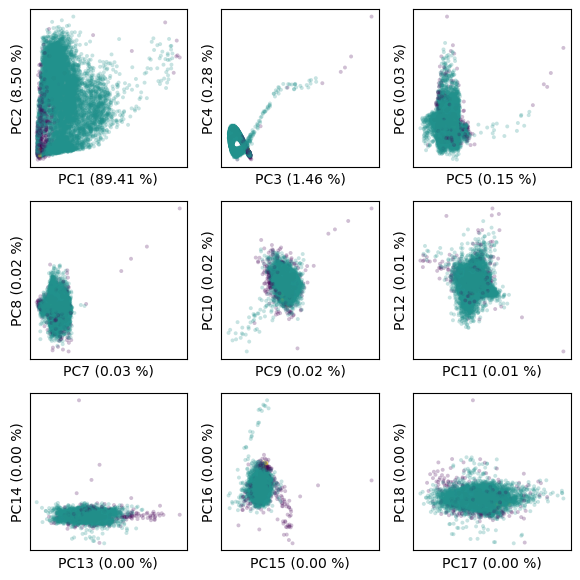

In [163]:
plot_embedding(
    pca_scores,
    explained_variances=pca_model.explained_variance_ratio_.copy(),
    colors=plot_labels,
    marker_size=8
)

## t-SNE

In [ ]:
tsne_model = TSNE(
    n_components=3, 
    perplexity=30, 
    learning_rate=200
)
tsne_embedding = tsne_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

DEBUG:debug:embedding combinations: 3
DEBUG:debug:plot_count: 3
DEBUG:debug:cols, rows: 3, 1


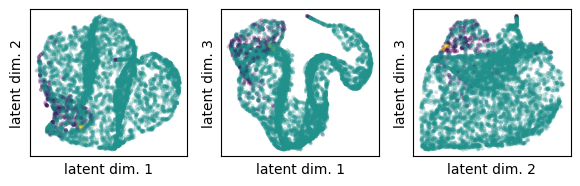

In [164]:
plot_embedding(
    tsne_embedding,
    colors=plot_labels,
    marker_size=8
)

## UMAP

In [166]:
umap_model = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.5)
umap_results = umap_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

DEBUG:debug:embedding combinations: 1
DEBUG:debug:plot_count: 1
DEBUG:debug:cols, rows: 1, 1


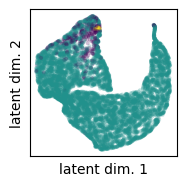

In [ ]:
plot_embedding(
    umap_results,
    colors=plot_labels,
    marker_size=8
)

In [161]:
%%writefile ./src/plotting_functions.py

import numpy as np
import matplotlib.pyplot as plt
import logging

db_logger = logging.getLogger(name='debug')
db_logger.setLevel(logging.DEBUG)

def plot_embedding(
    embedded_data,
    explained_variances=None,
    colors=None,
    marker_size:float=2.,
    return_figure:bool=False
):
    PERCENTAGE = 100
    CM = 1/2.54
    SUBPLOT_SIDE_SIZE = 5 * CM

    if explained_variances is not None: explained_variances *= PERCENTAGE

    embedding_dimension = embedded_data.shape[1]
    plot_combination_count = embedding_dimension * (embedding_dimension-1) // 2
    db_logger.debug(f'embedding combinations: {plot_combination_count}')
    
    if plot_combination_count <= 9:
        plot_count = plot_combination_count 
        col_count = np.min([3,plot_count])
        row_count = np.min([3,plot_count // col_count])
        embedding_indices_to_plot = [
            x 
            for x 
            in np.array(np.meshgrid(
                np.arange(embedding_dimension - 1),
                np.arange(embedding_dimension - 1) + 1
            ))\
              .T\
              .reshape(-1,2) 
            if len(np.unique(x)) > 1
        ]
    else:
        plot_count = embedding_dimension
        col_count = np.min([3,int(np.sqrt(plot_count))])
        row_count = np.min([3,int(np.sqrt(plot_count))])
        embedding_indices_to_plot = np.arange(0,col_count*row_count*2).reshape(-1,2)

    db_logger.debug(f'plot_count: {plot_count}')
    db_logger.debug(f'cols, rows: {col_count}, {row_count}')

    if colors is None: colors = [1] * len(embedded_data)

    fig, ax = plt.subplots(
        ncols=col_count,
        nrows=row_count,
        figsize=(col_count * SUBPLOT_SIDE_SIZE, row_count * SUBPLOT_SIDE_SIZE)
    )

    if col_count == 1:
        ax.scatter(
            x=embedded_data[:,0],
            y=embedded_data[:,1],
            s=marker_size,
            alpha=.25,
            c=colors,
            linewidth=0
        )

        x_lab = f'PC1 ({explained_variances[0]:.2f} %)' if explained_variances is not None else f'latent dim. 1'
        y_lab = f'PC2 ({explained_variances[1]:.2f} %)' if explained_variances is not None else f'latent dim. 2'

        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        ax.set_xticks([])
        ax.set_yticks([])

    elif col_count >= 2 and row_count == 1:
        for ndx,plot_ndx in enumerate(range(col_count)):
            ax[plot_ndx].scatter(
                x=embedded_data[:,embedding_indices_to_plot[ndx][0]],
                y=embedded_data[:,embedding_indices_to_plot[ndx][1]],
                s=marker_size,
                alpha=.25,
                c=colors,
                linewidth=0
            )

            x_lab = 'PC{} ({:.2f} %)'.format(
                embedding_indices_to_plot[ndx][0] +1,
                explained_variances[embedding_indices_to_plot[ndx][0]]
            ) if explained_variances is not None else 'latent dim. {}'.format(
                embedding_indices_to_plot[ndx][0] +1
            )
            y_lab = 'PC{} ({:.2f} %)'.format(
                embedding_indices_to_plot[ndx][1] +1,
                explained_variances[embedding_indices_to_plot[ndx][1]]
            ) if explained_variances is not None else 'latent dim. {}'.format(
                embedding_indices_to_plot[ndx][1] +1
            )            

            ax[plot_ndx].set_xlabel(x_lab)
            ax[plot_ndx].set_ylabel(y_lab)
            ax[plot_ndx].set_xticks([])
            ax[plot_ndx].set_yticks([])
    
    elif row_count >= 2:
        for ndx,plot_ndx in enumerate(range(col_count * row_count)):
            ax[plot_ndx // col_count,plot_ndx % row_count].scatter(
                x=embedded_data[:,embedding_indices_to_plot[ndx][0]],
                y=embedded_data[:,embedding_indices_to_plot[ndx][1]],
                s=marker_size,
                alpha=.25,
                c=colors,
                linewidth=0
            )

            x_lab = 'PC{} ({:.2f} %)'.format(
                embedding_indices_to_plot[ndx][0] +1,
                explained_variances[embedding_indices_to_plot[ndx][0]]
            ) if explained_variances is not None else 'latent dim. {}'.format(
                embedding_indices_to_plot[ndx][0] +1
            )
            y_lab = 'PC{} ({:.2f} %)'.format(
                embedding_indices_to_plot[ndx][1] +1,
                explained_variances[embedding_indices_to_plot[ndx][1]]
            ) if explained_variances is not None else 'latent dim. {}'.format(
                embedding_indices_to_plot[ndx][1] +1
            )

            ax[plot_ndx // col_count,plot_ndx % row_count].set_xlabel(x_lab)
            ax[plot_ndx // col_count,plot_ndx % row_count].set_ylabel(y_lab)
            ax[plot_ndx // col_count,plot_ndx % row_count].set_xticks([])
            ax[plot_ndx // col_count,plot_ndx % row_count].set_yticks([])

    fig.tight_layout()
    fig.show()

    if return_figure: return(fig)
    else: return(None)

Overwriting ./src/plotting_functions.py


# Plot map

In [ ]:
plot_data = np.zeros_like(
    np.arange(map_data.metadata.get('spectra'))
).astype(np.float32)
# plot_data += 2
plot_data[::STEP_SIZE] = plot_labels
plot_data = np.ma.array(plot_data, mask=np.isnan(plot_data))

In [ ]:
plot_data = plot_data.reshape(map_data.map_dimensions[::-1])
plot_data[::2,:] = plot_data[::2,::-1]

plt.imshow(plot_data,interpolation_stage='data', interpolation='none')